In [35]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report


In [75]:
import os

# Set working directory to where the zip file is located
project_dir = '/home/zero/AI ML/Workshop5'
os.chdir(project_dir)

# Confirm the current path and list of files
print(" Current Directory:", os.getcwd())
print(" Files available:", os.listdir())


 Current Directory: /home/zero/AI ML/Workshop5
 Files available: ['Untitled.ipynb', '.ipynb_checkpoints', 'FruitinAmazon.zip', 'train', 'best_model.h5', 'FruitCNN_FinalModel.h5', 'Polished_Worksheet5_CNN.ipynb', 'Untitled1.ipynb', 'final_model.keras', 'best_model.keras']


In [74]:
import zipfile

zip_path = 'FruitinAmazon.zip'
extract_to = './train'  # Folder to extract contents

# Extract the ZIP safely
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(" 'FruitinAmazon.zip' extracted to './train' folder!")


 'FruitinAmazon.zip' extracted to './train' folder!


In [73]:
# Check the immediate folder(s) inside the extracted 'train' directory
top_level = os.listdir('./train')
print(" Top-level folder(s) in './train':", top_level)

# Assuming structure is ./train/FruitinAmazon/train/classes
# Let's verify the actual dataset directory
train_dir = os.path.join('./train', 'FruitinAmazon', 'train')
class_names = sorted(os.listdir(train_dir))
print(" Detected Classes:", class_names)


 Top-level folder(s) in './train': ['FruitinAmazon']
 Detected Classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


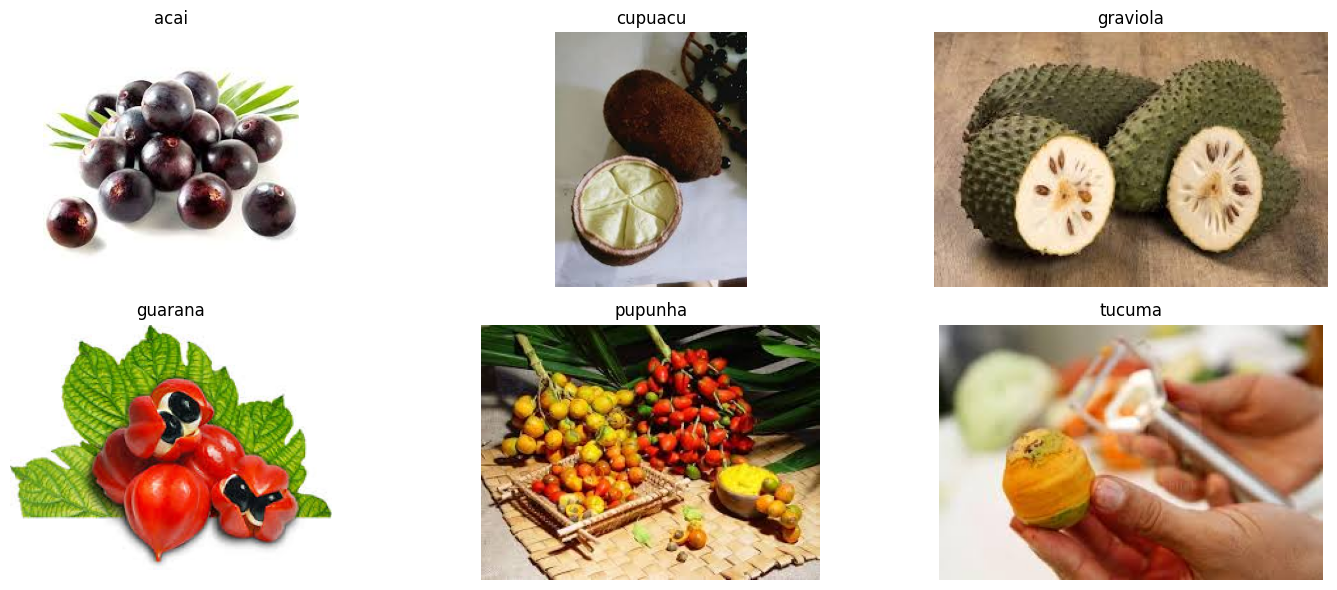

In [59]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Set random seed for reproducibility
random.seed(42)

# Create subplots: 2 rows, dynamic columns
fig, axs = plt.subplots(2, (len(class_names) + 1) // 2, figsize=(15, 6))
axs = axs.flatten()

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    img_file = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_file)
    
    # Load and show image
    image = Image.open(img_path)
    axs[i].imshow(image)
    axs[i].set_title(class_name)
    axs[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [72]:
from PIL import UnidentifiedImageError

corrupted_images = []

# Loop through each class and image
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path)
            img.verify()  # Check if image is broken
        except (UnidentifiedImageError, IOError, SyntaxError):
            corrupted_images.append(img_path)
            os.remove(img_path)
            print(f" Removed corrupted image: {img_path}")

# Report
if not corrupted_images:
    print(" No Corrupted Images Found!")
else:
    print(f" Total Corrupted Images Removed: {len(corrupted_images)}")


 No Corrupted Images Found!


In [71]:
import tensorflow as tf

# Set image dimensions and batch size
img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2
seed = 123  # for reproducibility

# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'  # keeps class labels as integers
)

# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

# Confirm class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(" Classes:", class_names)
print(" Number of Classes:", num_classes)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
 Classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
 Number of Classes: 6


In [62]:
# Create a normalization layer to scale pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [63]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [64]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),

    layers.Dense(num_classes, activation='softmax')
])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Setup callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1719 - loss: 2.0785 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.1623 - loss: 2.1947 - val_accuracy: 0.1111 - val_loss: 1.8832
Epoch 2/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.1719 - loss: 1.7735

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.1901 - loss: 1.7603 - val_accuracy: 0.1111 - val_loss: 1.7956
Epoch 3/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3672 - loss: 1.6167 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.3850 - loss: 1.6066 - val_accuracy: 0.2222 - val_loss: 1.7004
Epoch 4/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5234 - loss: 1.4712

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5256 - loss: 1.4634 - val_accuracy: 0.4444 - val_loss: 1.6848
Epoch 5/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5859 - loss: 1.2713

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5360 - loss: 1.2865 - val_accuracy: 0.3333 - val_loss: 1.6055
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5707 - loss: 1.1825 - val_accuracy: 0.3889 - val_loss: 1.7107
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5816 - loss: 0.9877 - val_accuracy: 0.3889 - val_loss: 1.8490
Epoch 8/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6172 - loss: 0.9536 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.6350 - loss: 0.9208 - val_accuracy: 0.2778 - val_loss: 1.4849
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6819 - loss: 0.8170 - val_accuracy: 0.3889 - val_loss: 1.6425
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7183 - loss: 0.6691 - val_accuracy: 0.3889 - val_loss: 1.5969
Epoch 11/250
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8438 - loss: 0.6266 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.8524 - loss: 0.5976 - val_accuracy: 0.5000 - val_loss: 1.4565
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8524 - loss: 0.5022 - val_accuracy: 0.3333 - val_loss: 1.6957
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8307 - loss: 0.4698 - val_accuracy: 0.3889 - val_loss: 1.5790
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8889 - loss: 0.3118 - val_accuracy: 0.4444 - val_loss: 1.5295
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9115 - loss: 0.3140 - val_accuracy: 0.3889 - val_loss: 1.8622
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9497 - loss: 0.2267 - val_accuracy: 0.3333 - val_loss: 2.0430
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9627 - loss: 0.1748 - val_accuracy: 0.5000 - val_loss: 1.6245
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9891 - loss: 0.1191 - val_accuracy: 0.5000 - val_los

In [66]:
# Load the best saved model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on validation data
val_loss, val_accuracy = best_model.evaluate(val_ds)
print(f"📊 Validation Loss: {val_loss:.4f}")
print(f"✅ Validation Accuracy: {val_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5000 - loss: 1.4565
📊 Validation Loss: 1.4565
✅ Validation Accuracy: 0.5000


In [68]:
# Optional: Save in the newer recommended format
best_model.save('final_model.keras')


In [69]:
import numpy as np
from sklearn.metrics import classification_report

# Get predictions and true labels from validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Generate classification report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
📋 Classification Report:

              precision    recall  f1-score   support

        acai       0.14      1.00      0.25         1
     cupuacu       1.00      0.50      0.67         2
    graviola       1.00      0.67      0.80         3
     guarana       0.67      0.40      0.50         5
     pupunha       0.33      0.25      0.29         4
      tucuma       1.00      0.67      0.80         3

    accuracy                           0.50        18
   macro avg       0.69      0.58      0.55        18
weighted avg       0.71      0.50      0.56        18



2025-04-03 08:34:32.566254: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


/home/zero/.conda/envs/devnagari-fcn/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


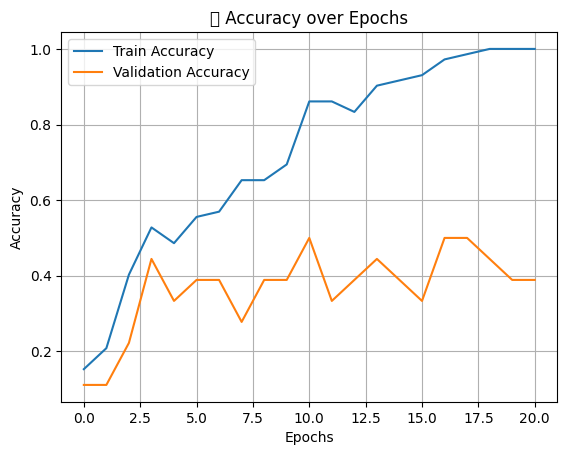

/home/zero/.conda/envs/devnagari-fcn/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


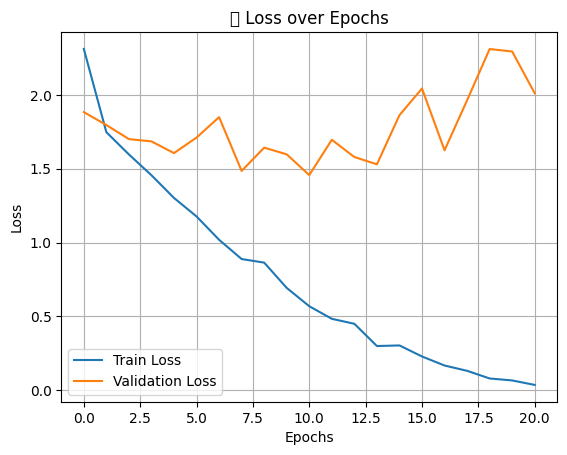

In [70]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('📈 Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('📉 Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
